# Introduction #

In this project we'll build an image classifier by attaching a head of dense layers to a pretrained base. The base we uses is from a model called **InceptionV1** (also known as GoogLeNet). InceptionV1 was one of the early winners of the ImageNet competition. One of its successors, InceptionV4, is among the state of the art today.


In [ ]:
# setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex1 import *

# imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# reproducability
def set_seed(seed=31415): #seed: for consistent results
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

# load training and validation sets - > assign 'label #'' to each folders in a dir
ds_train_ = image_dataset_from_directory( #loading data_set directly from dir
    '../input/car-or-truck/train',
    labels='inferred', # labels generated from dir - structure
    label_mode='binary', # encoding
    image_size=[128, 128], # resize to img: 128 X 128;
    interpolation='nearest', # interpolation method on resizing;
    batch_size=64,
    shuffle=True, # shuffle i/p when training;
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False, # sort data in alphanumeric order;
)

# data pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

2024-02-08 06:46:14.108004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 06:46:14.108136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 06:46:14.234072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


The **InceptionV1** model pretrained on ImageNet is available in the [TensorFlow Hub](https://www.tensorflow.org/hub/) repository.

In [ ]:
#load InceptionV1 for our base.
import tensorflow_hub as hub
pretrained_base = tf.keras.models.load_model(
    '../input/cv-course-models/cv-course-models/inceptionv1'
)

# 1. Define Pretrained Base #

Now we have a pretrained base to do our feature extraction, we've to decide whether this base should be trainable or not.

In [ ]:
pretrained_base.trainable = False #pretrained base weights not updated during training - prevent overfitting on re-training new head (if head has less # of data)

When doing transfer learning, it's generally not a good idea to retrain the entire `base`. The reason is that the random `weights` in the head will initially create large `gradient` updates, which propogate back into the `base` layers and destroy much of the `pretraining`. Using techniques known as `fine tuning` it's possible to further train the `base` on new data.

# 2. Attach Head #

Now that the base is defined to do the feature extraction, we then create a head of `Dense` layers to perform the classification, following this diagram:

<figure>
<img src="https://i.imgur.com/i5VU7Ry.png" alt="Diagram of the dense head.">
</figure>


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid') #transform the outputs to a probability score
])

# 3. Train #

Before training a model in Keras, we need to specify an *optimizer* to perform the gradient descent, a *loss function* to be minimized, and any *performance metrics*. The optimization algorithm we'll use is called ["Adam"](https://keras.io/api/optimizers/adam/), which generally performs well regardless of what kind of problem we're trying to solve.

The loss and the metrics, however, need to match the kind of problem we're trying to solve. Our problem is a **binary classification** problem: `Car` coded as `0`, and `Truck` coded as `1`.

In [ ]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss = 'binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [ ]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
)

Epoch 1/30


I0000 00:00:1707374815.559238     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 [==============================] - 30s 268ms/step - loss: 0.6726 - binary_accuracy: 0.5804 - val_loss: 0.6343 - val_binary_accuracy: 0.6046
Epoch 2/30
80/80 [==============================] - 4s 50ms/step - loss: 0.5688 - binary_accuracy: 0.7356 - val_loss: 0.4817 - val_binary_accuracy: 0.8024
Epoch 3/30
80/80 [==============================] - 4s 50ms/step - loss: 0.4474 - binary_accuracy: 0.8036 - val_loss: 0.4106 - val_binary_accuracy: 0.8242
Epoch 4/30
80/80 [==============================] - 4s 49ms/step - loss: 0.4035 - binary_accuracy: 0.8233 - val_loss: 0.3906 - val_binary_accuracy: 0.8311
Epoch 5/30
80/80 [==============================] - 4s 49ms/step - loss: 0.3842 - binary_accuracy: 0.8304 - val_loss: 0.3793 - val_binary_accuracy: 0.8379
Epoch 6/30
80/80 [==============================] - 4s 49ms/step - loss: 0.3711 - binary_accuracy: 0.8362 - val_loss: 0.3714 - val_binary_accuracy: 0.8408
Epoch 7/30
80/80 [==============================] - 4s 49ms/step - loss: 0.3607

# 4. Plot Loss & Accuracy #

Text(0.5, 1.0, 'binary accuracy')

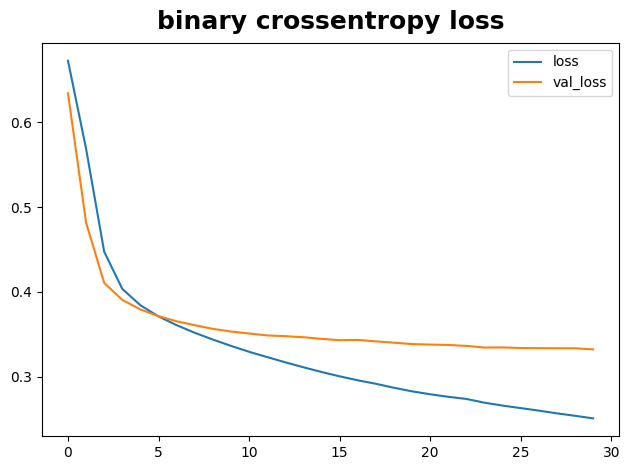

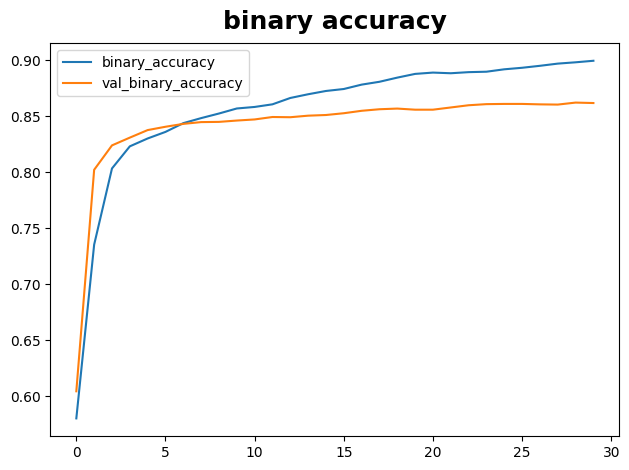

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.title('binary crossentropy loss')
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
plt.title('binary accuracy')

# 5. Examine Loss & Accuracy : InceptionV1 Model #



The training loss and validation loss stay fairly close is evidence that the model isn't just memorizing the training data, but rather learning general properties of the two classes. But, because this model converges at a loss greater than other model, e.g., VGG16 model, it's likely that it is underfitting some, and could benefit from some extra capacity.